## Run micrOMEGAs T13A

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import commands
import time

### DM relic density to $3\sigma$

In [3]:
#Experimental values for DM
#Reals values 2015
#Omega_max=0.1199+0.0022
#Omega_min=0.1199-0.0022
#Reals values 2013
#Omega_max=0.1199+0.0027
#Omega_min=0.1199-0.0027
e = 3
Omega_exp = 0.1199
Omega_err=0.0027
Omega_max=Omega_exp + e*Omega_err
Omega_min=Omega_exp - e*Omega_err
print Omega_exp, Omega_min,Omega_max

0.1199 0.1118 0.128


#### Rutine

In [4]:
#1. CHOOSE A BENCHMARK POINT    
def run_point(MDF = 110.,MN = 101.,tanb = 10.0,lam = 0.15,v=246.2196):
    o={}
    #2. File to run micrOMEGAS installed in galcen
    f1 = open("input.par","w") 

    lu=lam*np.sin(np.arctan(tanb))
    ld=lam*np.cos(np.arctan(tanb))
    

    M=np.matrix([[ MN,                -ld*v/np.sqrt(2.),  lu*v/np.sqrt(2.)],
             [ -ld*v/np.sqrt(2.),  0.,                MDF ],
             [ lu*v/np.sqrt(2.),  MDF,               0. ]])

    (Mchi,N)=np.linalg.eig(M)

    f1.write('MDF'+'\t'+str(MDF)+'\n'+'MN'+'\t'+str(MN)+'\n'+'ld'+'\t'+str(ld)+'\n'+'lu'+'\t'+str(lu)+'\n'\
        +'N11'+'\t'+str(N[0,0])+'\n'+'N12'+'\t'+str(N[0,1])+'\n'+'N13'+'\t'+str(N[0,2])+'\n'\
        +'N21'+'\t'+str(N[1,0])+'\n'+'N22'+'\t'+str(N[1,1])+'\n'+'N23'+'\t'+str(N[1,2])+'\n'\
        +'N31'+'\t'+str(N[2,0])+'\n'+'N32'+'\t'+str(N[2,1])+'\n'+'N33'+'\t'+str(N[2,2])+'\n')
    #Close file
    f1.close()     

    #3. Run micromegas
    mo=commands.getoutput('~/micromegas_4.2.5/T13A0/./main input.par')

    #4. Extrac some of the output (Dependence of the micrOMEGAs vertion)
    o['Omega']=eval(mo.split('Omega=')[1].split('\n')[0])
    o['SI']=eval(mo.split('proton  SI')[1].split('[')[0])
    o['SD']=eval(mo.split('proton  SI')[1].split('SD')[1].split('[')[0])
    o['sigmav']=eval(mo.split('annihilation cross section')[1].split('cm^3/s\n')[0])
    return o

In [5]:
mo=pd.Series(run_point(MDF=110))
mo.Omega

0.085300000000000001

# Markov chain

From hep-ph/0407039

Start at any point

In [6]:
def chi2(micrOMEGAs):
    Omega_exp = 0.1199
    Omega_err=0.0027
    return ( np.log(micrOMEGAs.Omega/Omega_exp)/(3.*Omega_err))**2

def L(micrOMEGAs):
    from decimal import Decimal
    return np.exp(Decimal(-chi2(micrOMEGAs)/2.))

def likelihood(chi2):
    from decimal import Decimal
    return np.exp(Decimal(-chi2/2.))

    
p0=pd.Series({'MDF':130})
mo=pd.Series(run_point(p0.MDF))
L0=likelihood(chi2(mo))
print L0

6.974005117964145981665798839E-5202


In [7]:
pnew=pd.Series({'MDF':114})#MDF+np.random.choice([+1,-1])*1.
print pnew.MDF
mo=pd.Series(run_point(pnew.MDF))

print chi2(mo)
print likelihood(chi2(mo))
p=likelihood(chi2(mo))/L0
print p

114
16.6664241374
0.0002403986265092158381945953807
3.447066964289712042852045487E+5197


If L1<L0 does not reject a point but assign some probability

In [8]:
def markov_step(chi20,chi2new,p0,pnew,step): 
    '''Advance a point in the parameter space
    from p0 to pnew by step according to a
    Markov-chain probability obtained by calculating
    the likelihood from chi20 and chi2new.
    p0,pnew,step are pandas series with exactly
    the same keys corresponding to the paramenter 
    space variables'''
    import copy    
    accept=False
    if np.abs(likelihood(chi20))>0:
        p=likelihood(chi2new)/likelihood(chi20)
    else:
        p=1.1
    
    
    if p>1:
        accept=True        
    else:
        if p>np.random.random():
            accept=True
    
        print 'False L, check p: accept=',accept
        
    if accept:
        p0=copy.deepcopy(pnew)
        chi20=chi2new
        
        
    #pnew=pd.Series({'MDF':p0.MDF+np.random.choice([+1,-1])*step.MDF})
    pnew=pd.Series()
    for k in p0.keys():
        pnew[k]=p0[k]+np.random.choice([+1,-1])*step[k]
        
    return chi20,chi2new,p0,pnew

In [9]:
p_ini=pd.Series({'MDF':200})
p_new=p_ini
mo=pd.Series(run_point(p_ini.MDF))
chi20=chi2(mo)
L0=likelihood(chi2(mo))
print chi20,L0,mo.Omega

350470.70445 1.792644737803656537921315276E-76104 14.5


In [10]:
import copy    
x=pd.DataFrame()

step0=pd.Series({'MDF':0.1})
for i in range(100):
    chi2new=chi2(mo)
    #Quite general way for step:
    s=pd.Series()
    step=step0
    if chi20>600000:
        step=step*1000    
    elif chi20>50000:
        step=step*100
    elif chi20>250:
        step=step*10
    
    chi20,chi2new,p_ini,p_new=markov_step(chi20,chi2new,p_ini,p_new,step)
        
    print 'p:',p,step.MDF,p_ini.MDF,p_new.MDF,mo.Omega,i
    s['MDF_0']=p_ini.MDF
    s['MDF_i']=p_new.MDF
    s['L0']=likelihood(chi20)
    s['L']=likelihood(chi2(mo))
    mo=pd.Series(run_point(p_new.MDF))
    s=s.append(mo)

    x=x.append(s,ignore_index=True)

False L, check p: accept= True
p: 3.447066964289712042852045487E+5197 10.0 200 190.0 14.5 0
p: 3.447066964289712042852045487E+5197 10.0 190.0 200.0 10.7 1
False L, check p: accept= False
p: 3.447066964289712042852045487E+5197 10.0 190.0 180.0 14.5 2
p: 3.447066964289712042852045487E+5197 10.0 180.0 190.0 7.53 3
False L, check p: accept= False
p: 3.447066964289712042852045487E+5197 10.0 180.0 190.0 10.7 4
False L, check p: accept= False
p: 3.447066964289712042852045487E+5197 10.0 180.0 190.0 10.7 5
False L, check p: accept= False
p: 3.447066964289712042852045487E+5197 10.0 180.0 170.0 10.7 6
p: 3.447066964289712042852045487E+5197 10.0 170.0 180.0 4.98 7
False L, check p: accept= False
p: 3.447066964289712042852045487E+5197 10.0 170.0 160.0 7.53 8
p: 3.447066964289712042852045487E+5197 10.0 160.0 170.0 3.06 9
False L, check p: accept= False
p: 3.447066964289712042852045487E+5197 10.0 160.0 150.0 4.98 10
p: 3.447066964289712042852045487E+5197 10.0 150.0 160.0 1.73 11
False L, check p: acc

In [91]:
ptmp=pnew
ptmp

MDF    125
dtype: float64

In [92]:
pnew={}
ptmp

MDF    125
dtype: float64

(-100, 1)

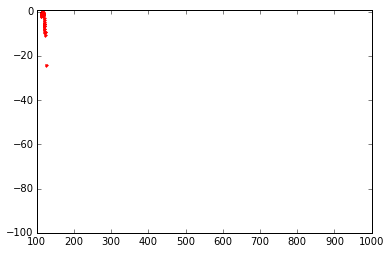

In [24]:
plt.plot(x.MDF_0,np.log10(x.L),'r.')
plt.ylim(-100,1)
#plt.ylim(1E-53,10)

TODO: Check likelihood for MDF=113

In [199]:
print p0.MDF
print L(mo.Omega)>L0

128.0
False


In [101]:
MDF=MDF+np.random.choice([+1,-1])*1.
print MDF
mo=pd.Series(run_point(MDF))
chi2=( np.log(mo.Omega/Omega_exp)/(3*Omega_err))*2
print chi2
L=np.exp(-chi2/2)
print 'O:',mo.Omega
p=L/L0
pnew=np.random.random()
if L>L0:
    MDF=MDF+np.random.choice([+1,-1])*1.
else
if p<pnew:
    print pnew
    MDF=MDF+np.random.choice([+1,-1])*1.
else:
    MDF=MDFold
    MDF=MDF+np.random.choice([+1,-1])*1.
print MDF

129.0
289.962290763
O: 0.388
129.0


In [10]:
print "========= SOME VALUES ==========="
print "Omega","\t", "SI","\t",  " SD","\t",  "sigmav"
print "=============================="
print Omega, SI,SD,"\t",sigmav
print "=============================="

========= SOME VALUES ===========
Omega 	SI 	 SD 	sigmav
0.0853 1.746e-09 0.0003883 	1.36e-26


Full micrOMEGAs output

In [9]:
mo.splitlines()

['',
 "Dark matter candidate is '~chi2' with spin=1/2 mass=8.96E+01",
 '',
 '=== MASSES OF HIGGS AND ODD PARTICLES: ===',
 'Higgs masses and widths',
 '      H   125.00 7.03E-03',
 '',
 'Masses of odd sector Particles:',
 '~chi : Mchi2 =    89.6 || ~X1n : MDF   =   110.0 || ~chi : Mchi1 =   111.9 ',
 '~chi : Mchi3 =   123.3 || ~sk  : Msk   =  3000.0 || ',
 '',
 '==== Calculation of relic density =====',
 'Xf=2.49e+01 Omega=8.53e-02',
 '# Channels which contribute to 1/(omega) more than 1%.',
 '# Relative contributions in % are displayed',
 '   69% ~chi2 ~chi2 ->W+ W- ',
 '    9% ~chi2 ~chi2 ->Z Z ',
 '    4% ~chi2 ~X1n ->u~ d ',
 '    4% ~chi2 ~X1n ->c~ s ',
 '    1% ~chi2 ~X1n ->ve~ e- ',
 '    1% ~chi2 ~X1n ->vm~ mu- ',
 '    1% ~chi2 ~X1n ->vt~ ta- ',
 'omega_h^2 = 8.53E-02',
 '',
 '==== Indirect detection =======',
 '    Channel          vcs[cm^3/s]',
 '==================================',
 ' annihilation cross section 1.36E-26 cm^3/s',
 ' contribution of processes',
 '  ~chi2,~chi

In [131]:
%%bash
#git init
#git add correr_micrOMEGAs-markov.ipynb
#git remote add origin git@gitlab.com:restrepo/markov.git
#git config --global user.name "rsiii"
#git config --global user.email "rsiii@gfif.udea.edu.co"
git commit -am "markov_step function ful"
git push origin master

[master 197e00f] first implementation of markov chain function
 1 file changed, 394 insertions(+), 121 deletions(-)


To git@gitlab.com:restrepo/markov.git
   d0edaed..197e00f  master -> master


Recover last commited version

In [ ]:
%%bash 
#git reset --hard $(git log | head -n1 | awk '{print $2}')